# **Mithila ART CLASSIFICATION MODEL**

## Install Necessary Dependencies

In [1]:
# !pip install tensorflow keras numpy matplotlib scikit-learn opencv-python
# !pip install pillow

### Import Required Libraries

In [ ]:
import os
import shutil
import albumentations as A
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16

*Key Insights*: 
- `os`, `shutil`: File handling and directory management.
- `albumentations`: Advanced augmentation library for image preprocessing.
- `cv2`: OpenCV for image manipulation.
- `PIL` and `numpy`: Handling image formats and numerical data.
- `tensorflow.keras`: Deep learning framework components for model design and optimization.

## Define Image Labels

In [3]:
image_labels = [
  "Mandala Art",
  "Mithila Painting",
  "Paubha Painting",
  "Thangka Painting"
]


*Key Insights*:  
- This list contains the names of four types of art styles: `Mandala Art`, `Mithila Painting`, `Paubha Painting`, and `Thangka Painting`.  
- These labels will later be mapped to the respective classes in our dataset and used for model predictions.  
- Ensuring the labels are descriptive and unique is critical for maintaining clarity in the classification task.  

## Define and Use a Function for Data Splitting

In [5]:
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

    # Validate ratios
    if train_ratio + val_ratio + test_ratio != 1.0:

        raise ValueError("Train, validation, and test ratios must sum to 1.")
    
    # Create destination folders
    for split in ['train', 'val', 'test']:

        split_path = os.path.join(dest_dir, split)

        os.makedirs(split_path, exist_ok=True)

    # Iterate over each class folder

    for class_name in os.listdir(source_dir):

        class_path = os.path.join(source_dir, class_name)

        if not os.path.isdir(class_path):

            continue

        # Get all files in the class folder

        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Split files into train, validation, and test sets

        train_files, temp_files = train_test_split(files, test_size=(1 - train_ratio), random_state=42)

        val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

        # Copy files to destination directories

        for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):

            split_class_dir = os.path.join(dest_dir, split, class_name)

            os.makedirs(split_class_dir, exist_ok=True)

            for file in split_files:

                shutil.copy(os.path.join(class_path, file), os.path.join(split_class_dir, file))

    print("Data successfully split into train, validation, and test sets.")

# Example usage:

source_directory = "/workspaces/machine-learning/projects/folk-art-classification/dataset"

destination_directory = "./data-set"

# split_data(source_directory, destination_directory)

*Key Insights*:  
1. **Ratio Validation**:  
   - The `train_ratio`, `val_ratio`, and `test_ratio` must sum to 1.0. Otherwise, the function raises an error to ensure proper dataset splitting.  
2. **Directory Creation**:  
   - Separate folders (`train`, `val`, `test`) are created within the destination directory to organize the data for each split.  
3. **Class-wise File Handling**:  
   - The function iterates through each class in the `source_dir`, and processes only valid directories (ignoring non-directory files).  
   - Files within each class directory are split using `train_test_split` from `sklearn`, ensuring a consistent random seed for reproducibility.  
4. **File Copying**:  
   - Files are copied into the respective split directories, preserving the class-wise folder structure within each split.  
5. **Print Confirmation**:  
   - After execution, the function confirms successful data splitting.  

*Usage Example*:  
- The `source_directory` is the folder containing all the original dataset class subdirectories.  
- The `destination_directory` is the output location for the split dataset, organized into `train`, `val`, and `test` directories.

## Apply and Save Augmented Images

In [6]:
# Define individual augmentations
specific_augmentations = {
    "rotation": A.Rotate(limit=40, p=1.0),
    "translation": A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0, p=1.0),
    "blur": A.GaussianBlur(blur_limit=(3, 7), p=1.0),
    "brightness_contrast": A.RandomBrightnessContrast(p=1.0),
    "horizontal_flip": A.HorizontalFlip(p=1.0),
}

# Input and output directories
input_dir = "./data-set/val"
output_dir = "./augmented-dataset/val"
n = 3

# Function to create necessary directories
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to apply and save augmentations
def save_augmented_images(image, output_class_path, img_name, augmentation, aug_name, count):
    for i in range(count):
        # Apply the augmentation
        augmented = augmentation(image=image)
        augmented_image = augmented["image"]

        # Convert back to BGR for saving
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

        # Save the augmented image
        output_filename = f"{os.path.splitext(img_name)[0]}_{aug_name}_aug_{i}.jpg"
        output_path = os.path.join(output_class_path, output_filename)
        cv2.imwrite(output_path, augmented_image)
        print(f"Saved: {output_path}")

# Function to augment images
def augment_images(input_dir, output_dir, n):
    for class_dir in os.listdir(input_dir):  # Iterate over each class directory
        input_class_path = os.path.join(input_dir, class_dir)
        output_class_path = os.path.join(output_dir, class_dir)

        # Create output directory for the class
        create_dir(output_class_path)

        if os.path.isdir(input_class_path):  # Check if it's a directory
            for img_name in os.listdir(input_class_path):
                img_path = os.path.join(input_class_path, img_name)

                # Read the image
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Failed to read image {img_path}")
                    continue

                # Convert BGR to RGB for Albumentations
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Apply each specific augmentation
                for aug_name, augmentation in specific_augmentations.items():
                    save_augmented_images(image, output_class_path, img_name, augmentation, aug_name, n)

# Run the augmentation
# augment_images(input_dir, output_dir, n)


*Purpose*: Augment validation images to increase data diversity.  
*Key Insights*:  
- **Augmentations**: Includes rotation, translation, blurring, brightness adjustment, and flipping.  
- **Directory Handling**: Ensures proper class-wise folder structure for augmented images.  
- **Multiple Augmentations**: Each augmentation applied `n` times per image for variety.  

## Convert Images to JPG Format


In [7]:
def convert_images_to_jpg(dataset_dir):

    # Supported extensions for conversion (excluding .svg)

    supported_extensions = ['.jpeg', '.png', '.gif', '.webp']

    # Traverse through the dataset directory

    for root, _, files in os.walk(dataset_dir):

        for file in files:

            file_path = os.path.join(root, file)
            file_name, file_ext = os.path.splitext(file)

            # Check if the file is an SVG

            if file_ext.lower() == '.svg':
                try:
                    os.remove(file_path)  # Delete the SVG file

                    print(f"Deleted SVG file: {file_path}")

                except Exception as e:

                    print(f"Error deleting SVG file {file_path}: {e}")

                continue  # Skip further processing for this file

            # Process other supported image types

            if file_ext.lower() in supported_extensions or file_ext.lower() == '.jpg':

                try:
                    # Open the image

                    img = Image.open(file_path).convert('RGB')

                    # New file path with the same directory but `.jpg` extension

                    new_file_path = os.path.join(root, f"{file_name}.jpg")
                    # Save the image as `.jpg`

                    img.save(new_file_path, 'JPEG')
                    # Delete the original file only if it's not already `.jpg`

                    if file_ext.lower() != '.jpg':

                        os.remove(file_path)

                    print(f"Converted and replaced: {file_path} -> {new_file_path}")

                except Exception as e:

                    print(f"Error converting {file_path}: {e}")

# Example usage

dataset_directory = "./data-set"

# convert_images_to_jpg(dataset_directory)


*Purpose*: Standardize all image files in the dataset to `.jpg` format and remove unsupported `.svg` files.  
*Key Insights*:  
- **Supported Formats**: Converts `.jpeg`, `.png`, `.gif`, and `.webp` images to `.jpg`.  
- **SVG Handling**: Deletes `.svg` files as they are unsupported.  
- **Efficient Conversion**: Converts images to RGB, saves as `.jpg`, and removes the original non-JPG files.  

##  Set Hyperparameters

In [8]:
img_size = (224, 224)
learning_rate = 0.0001
batch_size = 32

*Purpose*: Define key hyperparameters for preprocessing and training.  
*Key Insights*:  
- **Image Size**: Resize all images to `(224, 224)` for input consistency.  
- **Learning Rate**: Set to `0.0001` for gradual and stable model optimization.  
- **Batch Size**: Defined as `32` for balanced memory usage and training speed.  

## Define Dataset Paths

In [9]:
# Paths to dataset directories

train_dir = '/kaggle/input/mithila-art-classification-balanaced-dataset/balanced-dataset/train'

val_dir = '/kaggle/input/mithila-art-classification-balanaced-dataset/balanced-dataset/val'

test_dir = '/kaggle/input/mithila-art-classification-balanaced-dataset/balanced-dataset/test'

*Purpose*: Specify the directory paths for the training, validation, and test datasets.  
*Key Insights*:  
- **Paths**: Points to pre-organized, balanced dataset folders.  
- **Structure**: Separate directories for `train`, `val`, and `test` ensure clear dataset segregation.  

## Define Data Augmentation Pipeline

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.5),
    tf.keras.layers.RandomContrast(0.2),   # Adjust contrast
    tf.keras.layers.RandomTranslation(0.2, 0.2),  # Shift image randomly
])


*Purpose*: Create a sequence of image augmentations for real-time data augmentation during training.  
*Key Insights*:  
- **Augmentations**: Includes random flipping, rotation, zoom, contrast adjustment, and translation.  
- **Keras Layers**: Utilizes `tf.keras.layers` for easy integration with TensorFlow models.  

## Cell Title: Preprocess Images and Labels  

In [11]:
def preprocess(image, label, augment=False):

    image = tf.image.resize(image, img_size)

    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    if augment:

        image = data_augmentation(image)  # Apply data augmentation if specified

    return image, label

*Purpose*: Preprocess images by resizing, normalizing, and optionally augmenting them.  
*Key Insights*:  
- **Resizing**: Resizes images to `224x224`.  
- **Normalization**: Scales pixel values to the range `[0, 1]`.  
- **Augmentation**: Applies the augmentation pipeline if `augment=True`.  

## Prepare Dataset for Training/Validation

In [12]:
def prepare_dataset(directory, augment=False, shuffle=True):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',        # Infer labels from subdirectory names
        label_mode='categorical', # One-hot encoded labels
        image_size=img_size,      # Resize images
        batch_size=batch_size,    # Number of images per batch
        shuffle=shuffle           # Shuffle data (disable for test dataset)
    )
    dataset = dataset.map(lambda x, y: preprocess(x, y, augment=augment))  # Apply preprocessing
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance


*Purpose*: Load images from the directory, apply preprocessing, and prepare the dataset for training or validation.  
*Key Insights*:  
- **Loading Data**: Loads images from directory with automatic label inference and one-hot encoding.  
- **Preprocessing**: Applies resizing, normalization, and optional augmentation via the `preprocess` function.  
- **Shuffling**: Shuffling is enabled for training but can be disabled for the test dataset.  
- **Performance**: Uses `prefetch` for optimized input pipeline during training.

## Dataset Preparation

In [ ]:
train_dataset = prepare_dataset(train_dir, augment=False, shuffle=True) 
val_dataset = prepare_dataset(val_dir, augment=False, shuffle=True)
test_dataset = prepare_dataset(test_dir, augment=False, shuffle=True)

*Purpose*: Load images from directories, preprocess them, and prepare datasets for training, validation, and testing.  
*Key Insights*:  
- **Loading Data**: Reads images and labels from specified directories.  
- **Preprocessing**: Normalizes and resizes images; no augmentation is applied.  
- **Shuffling**: Ensures data is shuffled for randomness during training and evaluation.  

## Visualizing Training Samples

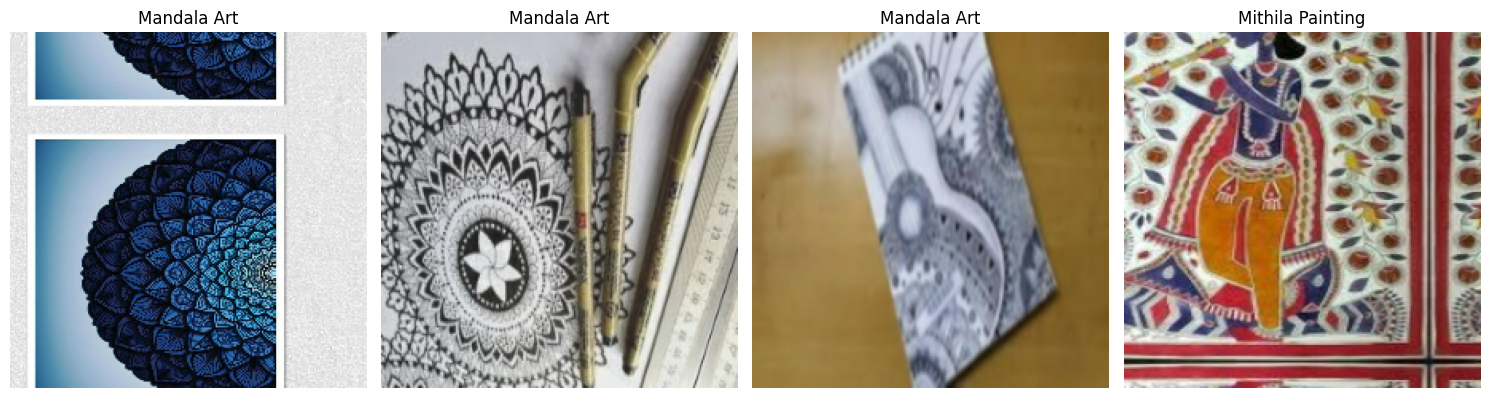

In [14]:
# Fetch a batch of images and labels from the training dataset
images, labels = next(iter(train_dataset))  # `train_dataset` is from the updated pipeline
# Define the number of images to display
num_images = 4
plt.figure(figsize=(15, 10))  # Create a larger figure for better visualization
# Loop through the number of images to display
for index in range(num_images):
    plt.subplot(1, num_images, index + 1)  # Create a subplot for each image
    plt.imshow(images[index].numpy())  # Display the image (convert Tensor to NumPy)
    class_label = labels[index].numpy().argmax()  # Get the class index from one-hot encoding
    class_name = image_labels[class_label]  # Get class name
    plt.title(class_name)  # Set the title to the class name
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

*Purpose*: Display a few sample images and their corresponding labels from the training dataset for visual inspection.  
*Key Insights*:  
- **Batch Fetching**: Retrieves a batch of images and labels from the `train_dataset`.  
- **Visualization Setup**: Uses Matplotlib to create subplots for displaying multiple images side by side.  
- **Image Display**: Converts image tensors to NumPy arrays and labels from one-hot encoding to class names.  
- **Purpose of Visualization**: Helps verify correct loading and preprocessing of data.

## Model Architecture Definition

In [15]:
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='sigmoid')
])


model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

*Purpose*: Define a deep learning model by fine-tuning a pre-trained VGG16 backbone and adding custom layers for the target task.  
*Key Insights*:  
- **Base Model**: Uses `VGG16` pre-trained on ImageNet with the top classification layer removed (`include_top=False`) for feature extraction.  
- **Trainability**: Sets `base_model.trainable = True` to fine-tune the VGG16 layers on the current dataset.  
- **Custom Layers**:  
  - **GlobalAveragePooling2D**: Reduces feature maps to a single value per filter, maintaining spatial invariance.  
  - **Dense Layers**: Adds fully connected layers with ReLU activation for feature learning.  
  - **Regularization**: Applies `l2` kernel regularization to prevent overfitting.  
  - **Batch Normalization**: Normalizes activations for stable and faster training.  
  - **Dropout**: Introduces dropout to reduce overfitting risks.  
- **Output Layer**: A dense layer with 4 output neurons and `sigmoid` activation, indicating a multi-label classification problem.  
- **Model Summary**: Prints the architecture and parameter details.  

## Model Compilation

In [16]:
optimizer = Adam(learning_rate=learning_rate,clipnorm=1.0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

*Purpose*: Compile the model by specifying the optimizer, loss function, and evaluation metrics.  
*Key Insights*:  
- **Optimizer**:  
  - `Adam`: Adaptive optimizer for efficient and adaptive learning rate adjustments.  
  - `clipnorm=1.0`: Clips gradients to prevent exploding gradients during training.  
- **Loss Function**: `categorical_crossentropy` is used, suitable for multi-class classification with one-hot encoded labels.  
- **Metrics**: Tracks `accuracy` during training and evaluation to monitor model performance.

## Setting Up TensorBoard Logging

In [17]:
# Define the log directory with custom naming convention
log_dir = os.path.join(
    "logs", 
    "fit", 
    f"VGG16_adam_{learning_rate}_{batch_size}"
)

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


*Purpose*: Set up TensorBoard logging with custom directory names based on model and hyperparameters.  
*Key Insights*:  
- **Log Directory**: Names the directory using model (`VGG16`), optimizer (`adam`), learning rate, and batch size.  
- **TensorBoard Callback**: Tracks and saves metrics, including weight histograms for each epoch.  
- **Benefit**: Organizes logs for easy comparison of different experiments.

## Early Stopping Callback

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=5,                # Number of epochs to wait before stopping
    restore_best_weights=True  # Restores the weights of the best epoch
)

*Purpose*: Set up early stopping to halt training if the validation loss doesn't improve for a specified number of epochs.  
*Key Insights*:  
- **Monitor Metric**: Tracks `val_loss` to determine when to stop training.  
- **Patience**: Waits for 5 epochs of no improvement before stopping.  
- **Restore Best Weights**: Ensures the model reverts to the best-performing weights from the training.  

## Learning Rate Scheduler

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


*Purpose*: Set up a learning rate scheduler to reduce the learning rate when the validation loss plateaus.  
*Key Insights*:  
- **Monitor Metric**: Tracks `val_loss` to detect when to reduce the learning rate.  
- **Factor**: Reduces the learning rate by a factor of 0.5 when triggered.  
- **Patience**: Waits for 2 epochs of no improvement before reducing the learning rate.  
- **Min Learning Rate**: Ensures the learning rate doesn’t go below `1e-6`.  
- **Verbose**: Prints a message when the learning rate is reduced.

## Model Training

In [21]:
history = model.fit(
    train_dataset,                # Training dataset
    epochs=30,                    # Adjust epochs as needed
    validation_data=val_dataset,  # Validation dataset
    callbacks=[tensorboard_callback,lr_scheduler, early_stopping]  # Include callbacks

)

Epoch 1/30


I0000 00:00:1733833747.922348      66 service.cc:145] XLA service 0x7dd784008ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733833747.922440      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733833771.832553      66 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_33', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_32', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_31', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_30', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtr

1279/1279 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5263 - loss: 3.4079

I0000 00:00:1733834053.086629      63 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_32', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_31', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_30', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_29', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_28', 12 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_24',

1279/1279 ━━━━━━━━━━━━━━━━━━━━ 321s 228ms/step - accuracy: 0.5264 - loss: 3.4072 - val_accuracy: 0.6357 - val_loss: 2.0643 - learning_rate: 1.0000e-04
Epoch 2/30
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 266s 208ms/step - accuracy: 0.8472 - loss: 1.1542 - val_accuracy: 0.8416 - val_loss: 0.8816 - learning_rate: 1.0000e-04
Epoch 3/30
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 266s 208ms/step - accuracy: 0.9353 - loss: 0.5435 - val_accuracy: 0.7941 - val_loss: 0.9269 - learning_rate: 1.0000e-04
Epoch 4/30
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 265s 208ms/step - accuracy: 0.9614 - loss: 0.3138 - val_accuracy: 0.8710 - val_loss: 0.6628 - learning_rate: 1.0000e-04
Epoch 5/30
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 265s 207ms/step - accuracy: 0.9724 - loss: 0.1971 - val_accuracy: 0.8371 - val_loss: 0.7583 - learning_rate: 1.0000e-04
Epoch 6/30
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9780 - loss: 0.1355
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 266s

### Key Insights:
- **Learning Rate Adjustment**: The learning rate is dynamically reduced to help the model converge more effectively as training progresses.
- **Model Performance**: The model's performance improves steadily, with high accuracy and low loss in later epochs.
- **Training Time**: Each epoch takes approximately 265-266 seconds to complete, indicating the computational cost of training with this architecture and dataset.

## Model Evaluation on Test Data

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.8817 - loss: 0.5790
Test Accuracy: 0.8918322324752808


*Purpose*: Evaluate the trained model's performance on the test dataset to measure generalization.  
*Key Insights*:  
- **Test Accuracy**: The model achieved an accuracy of **89.18%**, indicating strong generalization to unseen data.  
- **Test Loss**: The test loss is **0.5790**, reflecting the model's performance on the test set.  
- **Generalization**: The high accuracy suggests that the model performs well beyond the training and validation datasets.

## Model Accuracy Over Epochs

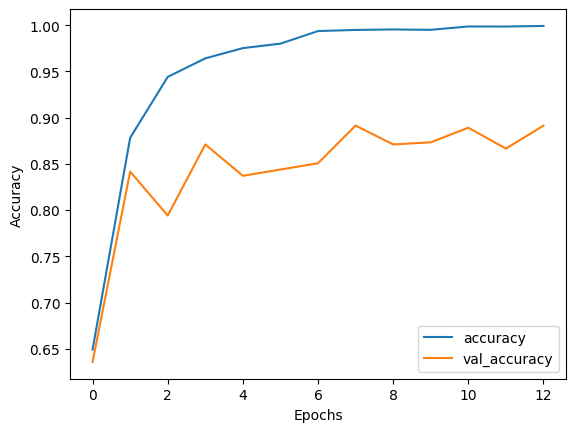

In [23]:
plt.plot(history.history['accuracy'], label='accuracy')

plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()

plt.show()

*Purpose*: Visualize the training and validation accuracy to evaluate the model's performance during training.  
*Key Insights*:  
- **Training Accuracy**: The training accuracy (blue line) steadily increases, reflecting continuous improvement as the model learns.
- **Validation Accuracy**: The validation accuracy (orange line) fluctuates, which is common as the model's generalization ability is tested on unseen data.
- **Overfitting Potential**: If the gap between training and validation accuracy grows significantly, it may indicate overfitting. And this is the case of overfitting, and the reason behind is the dataset, I have collected data by scrapping on google manually due to which my dataset have some wrong labeling, which led to overfitting.

## Model Loss Over Epochs

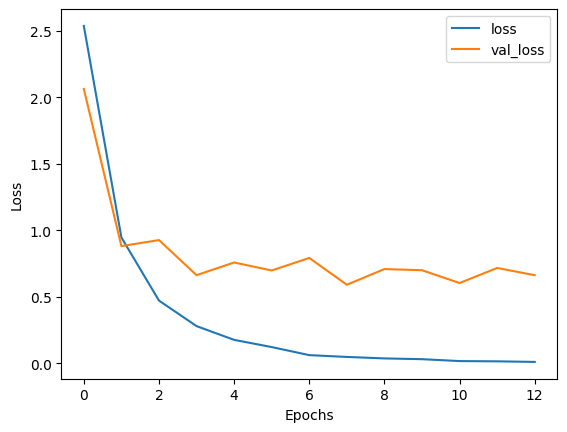

In [24]:
plt.plot(history.history['loss'], label='loss')

plt.plot(history.history['val_loss'], label='val_loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()

plt.show()

*Purpose*: Visualize the training and validation loss to evaluate the model's learning progress and generalization.

*Key Insights*:  
- **Training Loss**: The training loss (blue line) decreases significantly over the first few epochs, indicating that the model is learning and improving on the training data.
- **Validation Loss**: The validation loss (orange line) also decreases but at a slower rate, which is typical for unseen data. This suggests that the model is generalizing well.
- **Convergence**: Both the training and validation loss appear to stabilize after a few epochs, indicating the model is nearing its optimal performance on both the training and validation datasets.

## Saving the Trained Model

In [26]:
model.save('art-classification-custom-dataset-c4-v14-1.h5')

*Purpose*: Save the trained model to a file for later use, such as deployment or further evaluation.

*Key Insights*:  
- **Model Saving**: The model is saved in the HDF5 format (`.h5`), which includes the model architecture, weights, and optimizer state.  
- **Reusability**: Saving the model allows for easy reloading in the future without needing to retrain it.  
- **File Name**: The model is saved with the name `'art-classification-custom-dataset-c4-v14-1.h5'`, reflecting its version and specific task.

## Fetching a Batch of Test Data

In [28]:
test_images, test_labels = next(iter(test_dataset))

## Predicting with the Trained Model

In [29]:
img_predict = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


## Getting the True Label from One-Hot Encoding

In [30]:
np.argmax(test_labels[0])

3

## Getting the Predicted Label from One-Hot Encoding

In [31]:
np.argmax(img_predict[0])

3

## Visualizing Predictions vs. True Labels

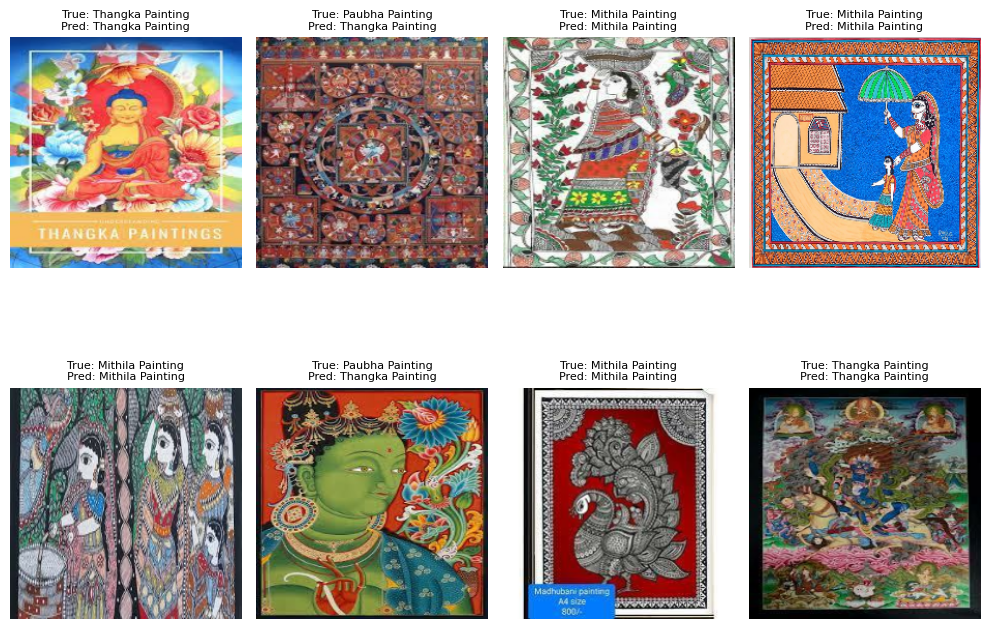

In [32]:
# Plotting
plt.figure(figsize=(10, 8))

for i in range(8):

    plt.subplot(2, 4, i + 1)  # Create a grid of subplots (2 rows, 4 columns)

    plt.imshow(test_images[i], cmap="gray")  # Display the image in grayscale

    # Get predicted and true class names

    predicted_class = image_labels[np.argmax(img_predict[i])]

    true_class = image_labels[np.argmax(test_labels[i])]
    # Display predicted and true class names

    plt.title(f"True: {true_class}\nPred: {predicted_class}", fontsize=8)

    plt.axis("off")  # Hide axes

plt.tight_layout()

plt.show()
